# Figure6 peaks overlap

## Plots

* Peaks overlap
* Peaks overlap with ENCODE MACS2 default
* Peaks overlap with ENCODE downloaded files
* Peaks overlap with ENCODE processed the same tool the same way.


## Input

* Peak Calling Summary - aging.tsv
* Peak Calling Summary - encode.tsv
* Downloaded GSM BED files for encode CD14+ at `/mnt/stripe/bio/experiments/figures`
* * GSM1003559_hg19_wgEncodeBroadHistoneMonocd14ro1746H3k27acPk.broadPeak
* * GSM1003564_hg19_wgEncodeBroadHistoneMonocd14ro1746H3k27me3Pk.broadPeak
* * GSM1003562_hg19_wgEncodeBroadHistoneMonocd14ro1746H3k36me3Pk.broadPeak
* * GSM1003535_hg19_wgEncodeBroadHistoneMonocd14ro1746H3k04me1Pk.broadPeak
* * GSM1003536_hg19_wgEncodeBroadHistoneMonocd14ro1746H3k04me3Pk.broadPeak



In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
from pathlib import Path
import downstream.bed_metrics as bm
import downstream.loci_of_interest as loi
import glob
from collections import OrderedDict, Counter
from IPython.display import display
import pandas as pd


OLD_COLOR = '#E41A1C'
YOUNG_COLOR = '#377EB8'
AGE_PALETTE = {'Old': OLD_COLOR, 'Young': YOUNG_COLOR}

TOOLS_PALETTE = {'MACS2': "#EDEDED", 'SICER': "#EDEDED", 'ZINBRA': '#FBE5D6'}

MODIFICATIONS = ['H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4me1', 'H3K4me3']

toshow = OrderedDict([
    ("H3K27ac", [("MACS2", "default"), ("ZINBRA", "tuned")]),
    ("H3K27me3", [("MACS2", "default"), ("SICER", "default"), ("ZINBRA", "tuned")]),
    ("H3K36me3", [("MACS2", "default"), ("SICER", "default"), ("ZINBRA", "tuned")]),
    ("H3K4me1", [("MACS2", "default"), ("ZINBRA", "tuned")]),
    ("H3K4me3", [("MACS2", "default"), ("ZINBRA", "tuned")])
])

df = pd.read_csv('/mnt/stripe/bio/experiments/figures/Peak Calling Summary - aging.tsv', sep='\t')
df = df.loc[df['Status'] != 'Failed'][['donor', 'modification', 'tool', 'peaks', 'procedure', 'file']]

In [2]:
# Compute overlaps
bigdf = pd.DataFrame(columns=['id', 'modification', 'tool', 'procedure', 'overlap', 'direction'])

for m, tps in toshow.items():
    for (tool, procedure) in tps:

        files = df.loc[np.logical_and(df['tool'] == tool, 
                          np.logical_and(df['modification'] == m, 
                                         df['procedure'] == procedure))]['file']
        
        paths = [Path(f) for f in files]
        df_path = '/mnt/stripe/bio/experiments/figures/overlap_{}_{}_{}.tsv'.format(m, tool, procedure)
        mt = bm.load_or_build_metrics_table(paths, paths, Path(df_path),
                                            jaccard=False,
                                            threads=30)
        for r in mt.index:
            for c in mt.columns:
                overlap = mt.loc[r][c]
                bigdf.loc[len(bigdf)] = (r + "@" + c, m, tool, procedure, overlap, 'all')

        # Look for replicated peaks
        if tool == 'ZINBRA':
            pattern='/mnt/stripe/bio/experiments/configs/Y20O20/benchmark/{}/zinbra_replicated/*any*.bed'.format(m)
            print(pattern)
            replicated_peaks = [Path(f) for f in glob.glob(pattern)]
            print(replicated_peaks)
            if len(replicated_peaks) != 1:
                print(replicated_peaks)
                print("ERROR")
# Ignore overlap with REPLICATED ZINBRA for now
#             df_path = '/mnt/stripe/bio/experiments/figures/overlap_replicated_vs_{}_{}_{}.tsv'.format(m, tool, procedure)
#             mt = bm.load_or_build_metrics_table(replicated_peaks, 
#                                                 paths, 
#                                                 Path(df_path),
#                                                 jaccard=False,
#                                                 threads=30)
#             for r in mt.index:
#                 for c in mt.columns:
#                     overlap = mt.loc[r][c]
#                     bigdf.loc[len(bigdf)] = (r + "@" + c, m, tool, procedure, overlap, 'replicated_vs')

#             df_path = '/mnt/stripe/bio/experiments/figures/overlap_vs_replicated_{}_{}_{}.tsv'.format(m, tool, procedure)
#             mt = bm.load_or_build_metrics_table(paths, 
#                                                 replicated_peaks, 
#                                                 Path(df_path),
#                                                 jaccard=False,
#                                                 threads=30)
#             for r in mt.index:
#                 for c in mt.columns:
#                     overlap = mt.loc[r][c]
#                     bigdf.loc[len(bigdf)] = (r + "@" + c, m, tool, procedure, overlap, 'vs_replicated')

[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_H3K27ac_MACS2_default.tsv
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_H3K27ac_ZINBRA_tuned.tsv
/mnt/stripe/bio/experiments/configs/Y20O20/benchmark/H3K27ac/zinbra_replicated/*any*.bed
[PosixPath('/mnt/stripe/bio/experiments/configs/Y20O20/benchmark/H3K27ac/zinbra_replicated/any_all_H3K27ac_1.0E-140_5_peaks.bed')]
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_H3K27me3_MACS2_default.tsv
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_H3K27me3_SICER_default.tsv
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_H3K27me3_ZINBRA_tuned.tsv
/mnt/stripe/bio/experiments/configs/Y20O20/benchmark/H3K27me3/zinbra_replicated/*any*.bed
[PosixPath('/mnt/stripe/bio/experiments/configs/Y20O20/benchmark/H3K27me3/zinbra_replicated/any_all_H3K27me3_1.0E-80_80_peaks.bed')]
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_H3K36m

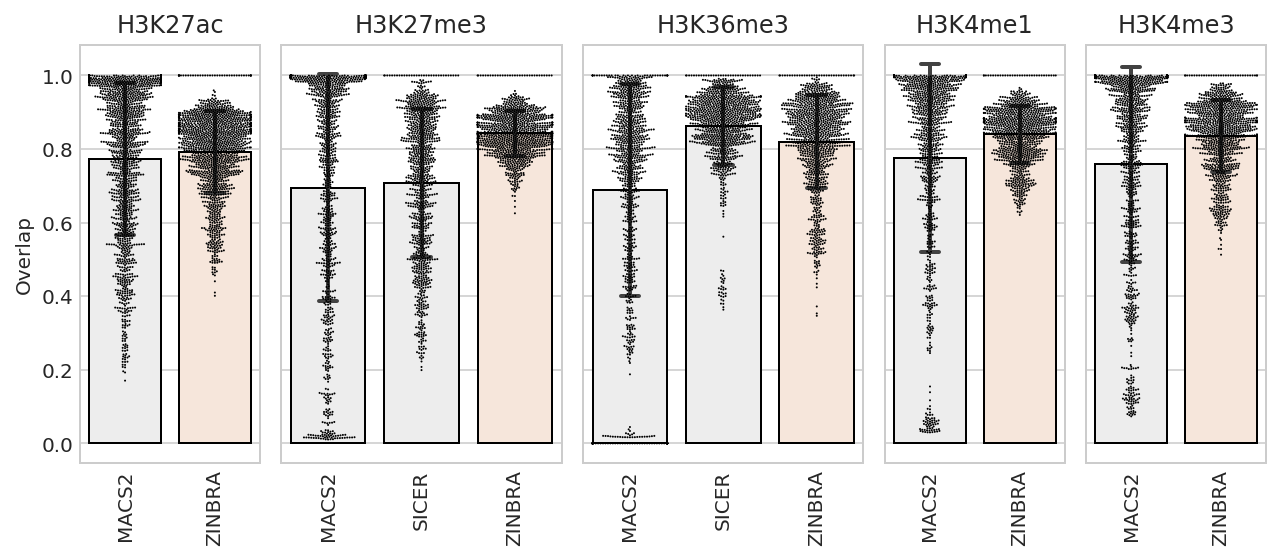

In [4]:
def plot_overlap(dft):
    dft['mp'] = dft['modification'] + " " + dft['tool'] + " " + dft['procedure']    

    axs = {}
    mpl = len(set(dft['mp']))
    fig = plt.figure(figsize=(int(len(set(dft['mp'])) * .75), 4))
    offset = 0
    for m in MODIFICATIONS:
        data = dft.loc[dft['modification'] == m]
        xlabels = []
        for t in data['tool']:
            if t not in xlabels:
                xlabels.append(t)
        w = len(set(data['mp']))
        ax = plt.subplot2grid((1, mpl), (0, offset), colspan=w)

        ax = sns.barplot(data=data, 
                 x="tool", y="overlap",
                 ci="sd", capsize=.2, errwidth=2,
                 palette = TOOLS_PALETTE,
                 edgecolor="black")

        ax = sns.swarmplot(data=data, 
                           x="tool", y="overlap",
                           size=1, alpha=1.0,
                           hue='direction',
                           palette={'all': 'black', 'replicated_vs': 'red', 'vs_replicated': 'yellow'})


        ax.legend().set_visible(False)
        axs[ax] = plt.ylim()
        if offset > 0:
            ax.get_yaxis().set_ticklabels([])
            ax.set_ylabel('')
        else:
            ax.set_ylabel('Overlap')
        
        offset += w
        ax.set_xlabel('')
        ax.set_title(m)
        plt.xticks(range(0, len(xlabels)), xlabels, rotation=90)
            
    ymin = np.min([v[0] for v in axs.values()])
    ymax = np.max([v[1] for v in axs.values()])
 
    for ax in axs.keys():
        ax.set_ylim(bottom = ymin, top = ymax)
    plt.tight_layout()

with PdfPages('/mnt/stripe/bio/experiments/figures/overlap.pdf') as pdf:
    plot_overlap(bigdf)
    pdf.savefig()

# CODE to plot 2 ways overlap with ENCODE

In [34]:
# Plot 2way overlaps on the single plot vs ENCODE with separation to red/blue
def plot_overlap2(dft):
    dft["age"] = "Young"
    dft.loc[["OD" in v for v in dft['id']], "age"] = "Old"

    
    total = len(set(dft['modification'] + " " + dft['tool'] + " " + dft['procedure']))
    
    dft['tool_binary'] = 'zinbra'
    dft.loc[dft['tool'] != 'ZINBRA', 'tool_binary'] = 'other'
    dft['mp'] = dft['direction']+ '-' + dft['tool_binary'] 

    TOOL_DIRECTION_PALETTE = {
        'aging@encode-zinbra': '#FBE5D6',
        'encode@aging-zinbra': '#FBE5D6',
        'aging@encode-other': '#EDEDED',
        'encode@aging-other': '#EDEDED',
    }
    
    ms = ['H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4me1', 'H3K4me3']
    axs = {}
    fig = plt.figure(figsize=(int(total * .75), 4))
    offset = 0
    for m in MODIFICATIONS:
        data = dft.loc[dft['modification'] == m]
        xlabels = []
        for t in data['tool']:
            if t not in xlabels:
                xlabels.append(t)
        w = len(set(data['tool']))
        ax = plt.subplot2grid((1, total), (0, offset), colspan=w)
        
        # Bar plots
        ax = sns.barplot(data=data, 
                         x="tool", y="overlap",
                         ci="sd", capsize=.2, errwidth=2,
                         color='#EDEDED',
#                          palette = TOOL_DIRECTION_PALETTE,
                         hue = "direction",
                         edgecolor="black",
                     )

#         ax = sns.barplot(data=data.loc[data['tool'] == 'ZINBRA'], 
#                          x="tool", y="overlap",
#                          ci="sd", capsize=.2, errwidth=2,
#                          color='#FBE5D6',
# #                          palette = TOOL_DIRECTION_PALETTE,
#                          hue = "direction",
#                          edgecolor="black",
#                         )


        # Add jitter with the swarmplot function.
        ax = sns.swarmplot(data=data.loc[data['age']=='Young'], 
                           x="tool", y="overlap",
                           size=3,
                           hue="direction",
                           palette=[YOUNG_COLOR, YOUNG_COLOR],
                           dodge=True)

        # Add jitter with the swarmplot function.
        ax = sns.swarmplot(data=data.loc[data['age']=='Old'], 
                           x="tool", y="overlap",
                           size=3,
                           hue="direction",
                           palette=[OLD_COLOR, OLD_COLOR],
                           dodge=True)

        ax.legend().set_visible(False)
        axs[ax] = plt.ylim()
        if offset > 0:
            ax.get_yaxis().set_ticklabels([])
            ax.set_ylabel('')
        else:
            ax.set_ylabel('Overlap')
        
        offset += w
        ax.set_xlabel('')
        ax.set_title(m)
        plt.xticks(range(0, len(xlabels)), xlabels, rotation=90)
            
    ymin = np.min([v[0] for v in axs.values()])
    ymax = np.max([v[1] for v in axs.values()])
 
    for ax in axs.keys():
        ax.set_ylim(bottom = ymin, top = ymax)
#     plt.tight_layout()

# Overlap with ENCODE MACS2 default

In [ ]:
import os
from scripts.util import run

dfe = pd.read_csv('/mnt/stripe/bio/experiments/figures/Peak Calling Summary - encode.tsv', sep='\t')
dfe = dfe[['donor', 'modification', 'tool', 'peaks', 'procedure', 'file']]
dfe = dfe.loc[np.logical_and(dfe['tool'] == 'MACS2', dfe['procedure'] == 'default')]
display(dfe)

method = 'union'
encode_macs2_peaks = {}
for modification in set(dfe['modification']):
    result_file = '/mnt/stripe/bio/experiments/figures/{}_encode_{}.bed'.format(modification, method)
    if not os.path.exists(result_file):
        files = list(dfe.loc[dfe['modification'] == modification]['file'])
        cmd = ['bash', '/mnt/stripe/washu/bed/{}.sh'.format(method)] + files
        with open(result_file, mode='w') as out:
            run([cmd], stdout=out)
    encode_macs2_peaks[modification] = result_file
display(encode_macs2_peaks)

H3K27ac MACS2 default
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_aging_at_encode_macs2_union_H3K27ac_MACS2_default.tsv
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_encode_at_aging_macs2_union_H3K27ac_MACS2_default.tsv
H3K27ac ZINBRA tuned
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_aging_at_encode_macs2_union_H3K27ac_ZINBRA_tuned.tsv
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_encode_at_aging_macs2_union_H3K27ac_ZINBRA_tuned.tsv
H3K27me3 MACS2 default
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_aging_at_encode_macs2_union_H3K27me3_MACS2_default.tsv
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_encode_at_aging_macs2_union_H3K27me3_MACS2_default.tsv
H3K27me3 SICER default
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_aging_at_encode_macs2_union_H3K27me3_SICER_default.tsv
[Skipped]: Already exists /mnt/stripe/bio/

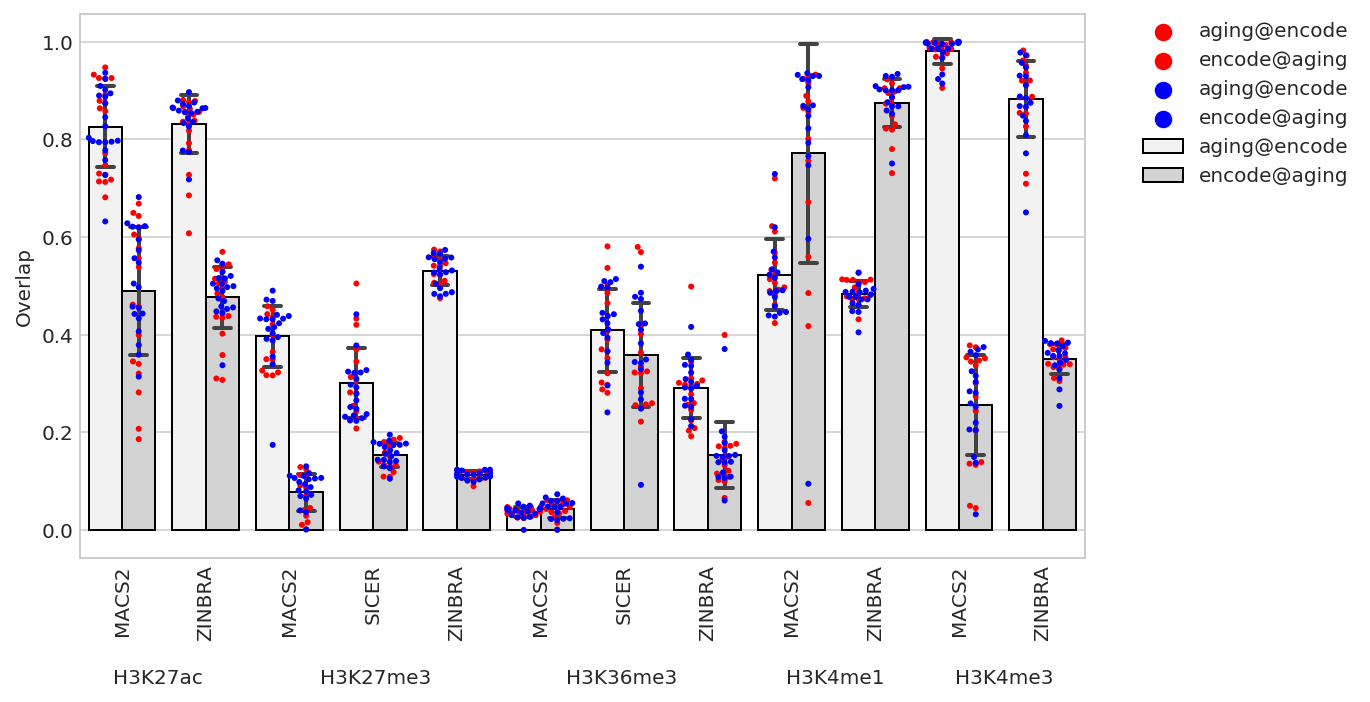

In [131]:
bigdf = pd.DataFrame(columns=['id', 'modification', 'tool', 'procedure', 'overlap', 'direction'])
xlabels = []
for m, tps in toshow.items():
    for (tool, procedure) in tps:
        xlabels.append(tool)
        print(m, tool, procedure)
        files = df.loc[np.logical_and(df['tool'] == tool, 
                          np.logical_and(df['modification'] == m, 
                                         df['procedure'] == procedure))]['file']
        # Aging @ ENCODE
        dfe_path = '/mnt/stripe/bio/experiments/figures/overlap_aging_at_encode_macs2_{}_{}_{}_{}.tsv'\
        .format(method, m, tool, procedure)
        aging_at_encode = bm.load_or_build_metrics_table([Path(f) for f in files],
                                             [Path(encode_macs2_peaks[modification])],
                                             Path(dfe_path),
                                            jaccard=False,
                                            threads=30)  
        for r in aging_at_encode.index:
            for c in aging_at_encode.columns:
                bigdf.loc[len(bigdf)] = (r + "@" + c, m, tool, procedure, aging_at_encode.loc[r][c], "aging@encode")
        
        # ENCODE @ Aging
        dfe_path = '/mnt/stripe/bio/experiments/figures/overlap_encode_at_aging_macs2_{}_{}_{}_{}.tsv'\
        .format(method, m, tool, procedure)
        encode_at_aging = bm.load_or_build_metrics_table([Path(encode_macs2_peaks[modification])],
                                            [Path(f) for f in files],
                                             Path(dfe_path),
                                            jaccard=False,
                                            threads=30)  
        for r in encode_at_aging.index:
            for c in encode_at_aging.columns:
                bigdf.loc[len(bigdf)] = (r + "@" + c, m, tool, procedure, encode_at_aging.loc[r][c], "encode@aging")


plot_overlaps_2(bigdf, xlabels)

# VS ENCODE downloaded BED files
Actuallly this is not the 100% truth, since we get some females here as well as tool bias.

H3K27ac MACS2 default
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_aging_at_encode_bed_union_H3K27ac_MACS2_default.tsv
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_encode_at_aging_bed_union_H3K27ac_MACS2_default.tsv
H3K27ac ZINBRA tuned
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_aging_at_encode_bed_union_H3K27ac_ZINBRA_tuned.tsv
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_encode_at_aging_bed_union_H3K27ac_ZINBRA_tuned.tsv
H3K27me3 MACS2 default
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_aging_at_encode_bed_union_H3K27me3_MACS2_default.tsv
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_encode_at_aging_bed_union_H3K27me3_MACS2_default.tsv
H3K27me3 SICER default
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_aging_at_encode_bed_union_H3K27me3_SICER_default.tsv
[Skipped]: Already exists /mnt/stripe/bio/experiments/fi

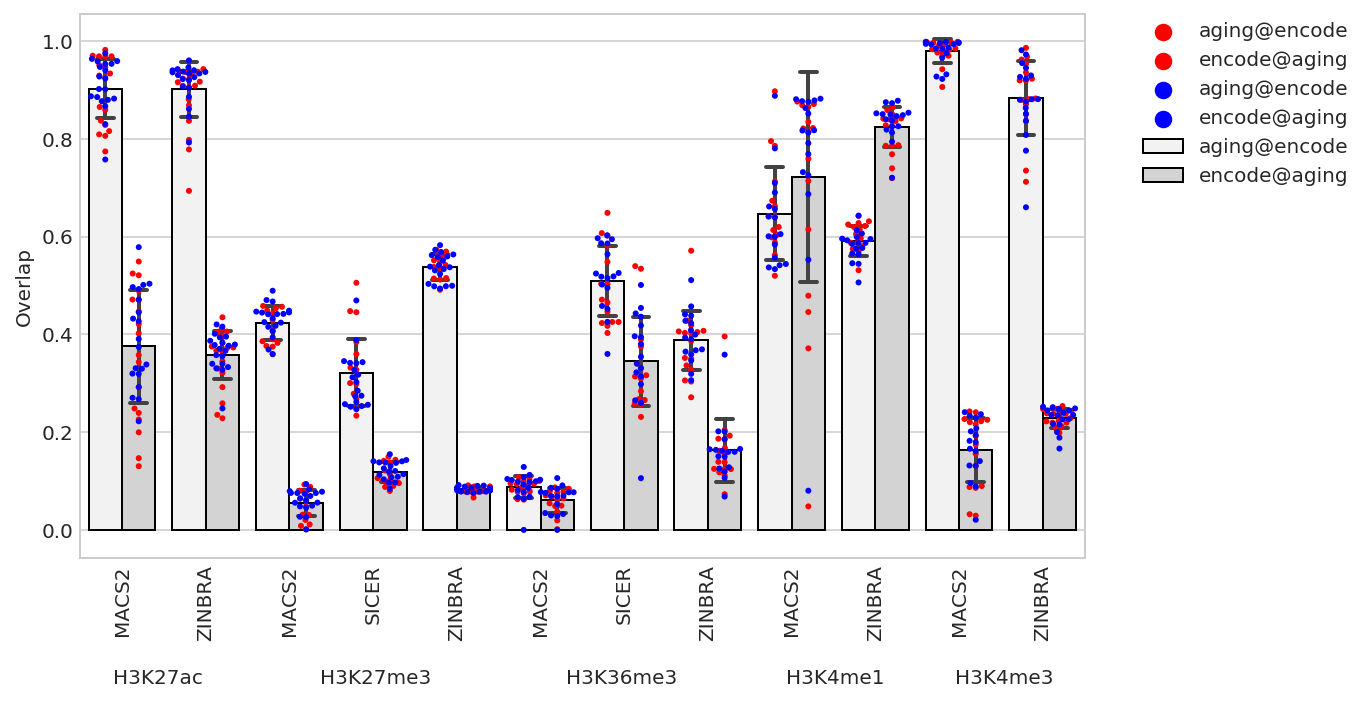

In [132]:
encode_peaks_bed={
    'H3K27ac': '/mnt/stripe/bio/experiments/figures/GSM1003559_hg19_wgEncodeBroadHistoneMonocd14ro1746H3k27acPk.broadPeak',
    'H3K27me3': '/mnt/stripe/bio/experiments/figures/GSM1003564_hg19_wgEncodeBroadHistoneMonocd14ro1746H3k27me3Pk.broadPeak',
    'H3K36me3': '/mnt/stripe/bio/experiments/figures/GSM1003562_hg19_wgEncodeBroadHistoneMonocd14ro1746H3k36me3Pk.broadPeak',
    'H3K4me1': '/mnt/stripe/bio/experiments/figures/GSM1003535_hg19_wgEncodeBroadHistoneMonocd14ro1746H3k04me1Pk.broadPeak',
    'H3K4me3': '/mnt/stripe/bio/experiments/figures/GSM1003536_hg19_wgEncodeBroadHistoneMonocd14ro1746H3k04me3Pk.broadPeak'
}

bigdf = pd.DataFrame(columns=['id', 'modification', 'tool', 'procedure', 'overlap', 'direction'])
xlabels = []
for m, tps in toshow.items():
    for (tool, procedure) in tps:
        xlabels.append(tool)
        print(m, tool, procedure)
        files = df.loc[np.logical_and(df['tool'] == tool, 
                          np.logical_and(df['modification'] == m, 
                                         df['procedure'] == procedure))]['file']
        # Aging @ ENCODE
        dfe_path = '/mnt/stripe/bio/experiments/figures/overlap_aging_at_encode_bed_{}_{}_{}_{}.tsv'\
        .format(method, m, tool, procedure)
        aging_at_encode = bm.load_or_build_metrics_table([Path(f) for f in files],
                                             [Path(encode_peaks_bed[modification])],
                                             Path(dfe_path),
                                            jaccard=False,
                                            threads=30)  
        for r in aging_at_encode.index:
            for c in aging_at_encode.columns:
                bigdf.loc[len(bigdf)] = (r + "@" + c, m, tool, procedure, aging_at_encode.loc[r][c], "aging@encode")
        
        # ENCODE @ Aging
        dfe_path = '/mnt/stripe/bio/experiments/figures/overlap_encode_at_aging_bed_{}_{}_{}_{}.tsv'\
        .format(method, m, tool, procedure)
        encode_at_aging = bm.load_or_build_metrics_table([Path(encode_peaks_bed[modification])],
                                            [Path(f) for f in files],
                                             Path(dfe_path),
                                            jaccard=False,
                                            threads=30)  
        for r in encode_at_aging.index:
            for c in encode_at_aging.columns:
                bigdf.loc[len(bigdf)] = (r + "@" + c, m, tool, procedure, encode_at_aging.loc[r][c], "encode@aging")


plot_overlaps_2(bigdf, xlabels)

# Overlap with ENCODE processed the same manner

In [6]:
import glob

# ENCODE male CD14 samples
encode_gsms = {
    'H3K27ac': 'GSM1102782',
    'H3K27me3': 'GSM1102785',
    'H3K36me3': 'GSM1102788',
    'H3K4me1': 'GSM1102793',
    'H3K4me3': 'GSM1102797',
}

bigdf = pd.DataFrame(columns=['id', 'modification', 'tool', 'procedure', 'overlap', 'direction'])
xlabels = []
for m, tps in toshow.items():
    for (tool, procedure) in tps:
        xlabels.append(tool)
        print(m, tool, procedure)
        files = df.loc[np.logical_and(df['tool'] == tool, 
                          np.logical_and(df['modification'] == m, 
                                         df['procedure'] == procedure))]['file']
        # Add encode overlap index
        if procedure == 'tuned':
            pattern = '/mnt/stripe/bio/experiments/configs/benchmark_encode/benchmark/{}/{}'
        else:
            pattern = '/mnt/stripe/bio/experiments/configs/benchmark_encode/default/{}/{}'
        if tool == 'ZINBRA':
            f = 'zinbra'
        elif tool == 'SICER':
            f = 'sicer'
        elif tool == 'MACS2':
            f = 'macs_broad'
        else: 
            print("Unknown tool")
        folder = pattern.format(m, f)
        encode_paths = []
        encode_paths.extend(glob.glob(folder + '/*' + encode_gsms[m] + '*.broadPeak'))
        encode_paths.extend(glob.glob(folder + '/*' + encode_gsms[m] + '*.narrowPeak')) 
        encode_paths.extend(glob.glob(folder + '/*' + encode_gsms[m] + '*.bed'))
#         print("ENCODE paths", encode_paths)
#         print("FILES", len(files))
        if len(encode_paths) == 0:
            print("ERROR")
        
        # Compute Aging @ ENCODE overlap
        dfe_path = '/mnt/stripe/bio/experiments/figures/overlap_aging_at_encode_{}_{}_{}_{}.tsv'\
            .format('tuned', m, tool, procedure)
        mte = bm.load_or_build_metrics_table([Path(f) for f in files], 
                                             [Path(f) for f in encode_paths],
                                             Path(dfe_path),
                                            jaccard=False,
                                            threads=30)  
        for r in mte.index:
            for c in mte.columns:
                overlap = mte.loc[r][c]
                bigdf.loc[len(bigdf)] = (r + "@" + c, m, tool, procedure, overlap, "aging@encode")

        # Compute ENCODE @ Aging overlap
        dfe_path = '/mnt/stripe/bio/experiments/figures/overlap_encode_at_aging_{}_{}_{}_{}.tsv'\
            .format('tuned', m, tool, procedure)
        mte = bm.load_or_build_metrics_table([Path(f) for f in encode_paths],
                                             [Path(f) for f in files],
                                             Path(dfe_path),
                                            jaccard=False,
                                            threads=30)  
        for r in mte.index:
            for c in mte.columns:
                overlap = mte.loc[r][c]
                bigdf.loc[len(bigdf)] = (r + "@" + c, m, tool, procedure, overlap, "encode@aging")

H3K27ac MACS2 default
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_aging_at_encode_tuned_H3K27ac_MACS2_default.tsv
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_encode_at_aging_tuned_H3K27ac_MACS2_default.tsv
H3K27ac ZINBRA tuned
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_aging_at_encode_tuned_H3K27ac_ZINBRA_tuned.tsv
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_encode_at_aging_tuned_H3K27ac_ZINBRA_tuned.tsv
H3K27me3 MACS2 default
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_aging_at_encode_tuned_H3K27me3_MACS2_default.tsv
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_encode_at_aging_tuned_H3K27me3_MACS2_default.tsv
H3K27me3 SICER default
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_aging_at_encode_tuned_H3K27me3_SICER_default.tsv
[Skipped]: Already exists /mnt/stripe/bio/experiments/figures/overlap_encode_at_agin

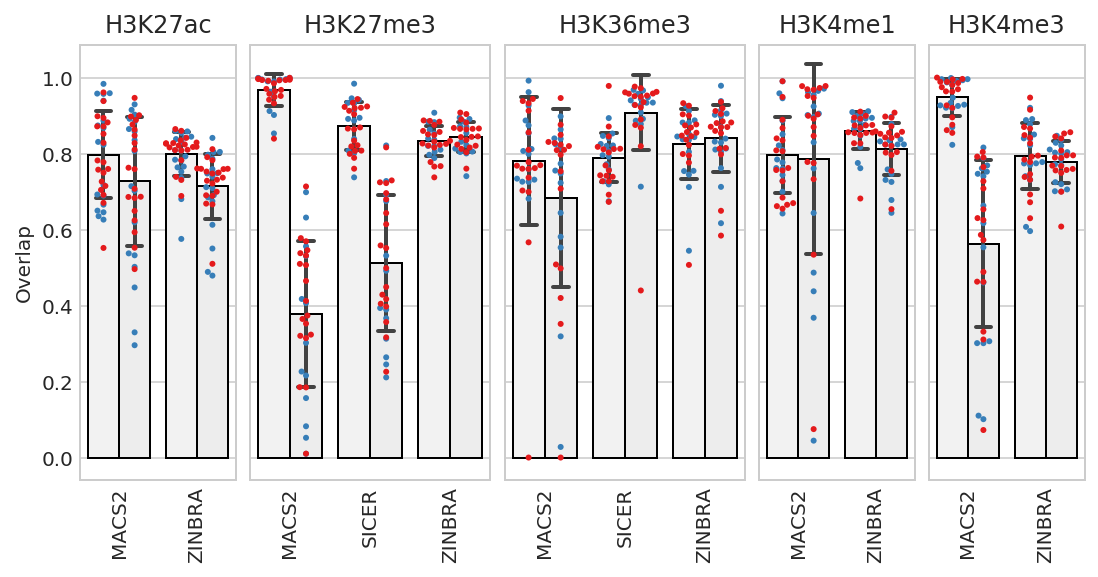

In [35]:
with PdfPages('/mnt/stripe/bio/experiments/figures/encode_overlap.pdf') as pdf:
    plot_overlap2(bigdf)
    pdf.savefig()